In [1]:
# tools

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query Arxiv for papers on a given topic", name="arxiv_query_run")

print(arxiv.description)

Query Arxiv for papers on a given topic


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query Wikipedia for information on a given topic", name="wiki_query_run")
wiki.name

'wiki_query_run'

In [5]:
from dotenv import load_dotenv
load_dotenv()  # Loads from .env into os.environ

import os

# Access the keys as needed
tavily_key = os.getenv("TAVILY_API_KEY")
groq_key = os.getenv("GROQ_API_KEY")


In [6]:
from langchain_community.tools import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\COM\AppData\Local\Temp\ipykernel_3428\3199068605.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


ValidationError: 1 validation error for TavilySearchAPIWrapper
  Value error, Did not find tavily_api_key, please add an environment variable `TAVILY_API_KEY` which contains it, or pass `tavily_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error

In [ ]:
tavily.invoke("Provide me the current AI news.")

[{'title': 'AI News Briefs BULLETIN BOARD for July 2025',
  'url': 'https://radicaldatascience.wordpress.com/2025/07/17/ai-news-briefs-bulletin-board-for-july-2025/',
  'content': '[7/14/2025] Windsurf’s CEO goes to Google; OpenAI’s acquisition falls apart – Google DeepMind hired Windsurf CEO Varun Mohan, co-founder Douglas Chen, and key researchers after OpenAI’s $3 billion acquisition attempt failed. Google gains a nonexclusive license to Windsurf’s technology, enhancing its AI coding capabilities without direct control. Windsurf faces uncertainty as it loses top talent, continuing to offer AI coding tools with Jeff Wang as interim CEO. [...] [7/14/2025] Apple Will Seriously Consider Buying Mistral – Apple is seriously considering acquiring Mistral, a French AI startup that has raised a total of €1.1 billion over seven funding rounds. Mistral has launched a range of large and small language models over the years and achieved notable success with its optical character recognition feat

In [ ]:
## combine all these tools in the list
tools = [arxiv, wiki, tavily]


In [ ]:
## initialize the LLM model
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="qwen/qwen3-32b",
    api_key=groq_key
    
    )

In [ ]:
llm.invoke("What is the latest research on AI?")

AIMessage(content="<think>\nOkay, the user is asking about the latest research on AI. Let me start by recalling the key areas that have been trending recently. First, there's the development of large language models like GPT-4 and other models from various companies. These models are getting bigger and more capable, with improvements in training efficiency and performance. I should mention the push towards more efficient training methods, maybe even the use of reinforcement learning from human feedback (RLHF). Oh, and there's been a lot about multimodal models that combine text, images, and maybe even audio. Projects like Google's Gemini or Meta's models come to mind.\n\nThen there's the area of AI alignment and safety. Researchers are really focused on making sure AI systems behave as intended, especially with the risks of large models. Techniques like constitutional AI from Anthropic or iterative alignment training from Google are probably important to note. Also, the concept of AI g

In [ ]:
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
### execute this call
llm_with_tools.invoke("What is the latest research on AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the latest research on AI. I need to figure out which tool to use here. Let me check the available functions. There\'s arxiv_query_run, wiki_query_run, and tavily_search_results_json. \n\nArxiv is a repository for academic papers, so using arxiv_query_run would give the latest research papers. Wiki might be outdated since Wikipedia isn\'t always the latest. Tavily seems to be a search tool, but I\'m not sure if it\'s specific to AI or general web search. The user wants the latest research, so arxiv is probably the best bet. Let me go with arxiv_query_run and use the query "latest AI research" to get recent papers.\n', 'tool_calls': [{'id': '4y5ajkef9', 'function': {'arguments': '{"query":"latest AI research"}', 'name': 'arxiv_query_run'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 176, 'prompt_tokens': 271, 'total_tokens': 447, 'completion_time': 0.437325371

### workflow

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph import add_messages

In [ ]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
### entire chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

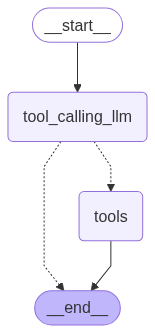

In [ ]:
### Node defintion
def tool_calling_llm(state: State) -> dict:
    """Call the LLM with the tools."""
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build the graph
graph = StateGraph(State)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

## Edges
graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm", 
    tools_condition,
)
graph.add_edge("tools", END)

graph_ = graph.compile()
# view
display(Image(graph_.get_graph().draw_mermaid_png()))

In [ ]:

messages = graph_.invoke({"messages": "Hey, what is the recent AI news and then please tell me about the latest research on quantum computing "})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hey, what is the recent AI news and then please tell me about the latest research on quantum computing 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (rdbvn5z7j)
 Call ID: rdbvn5z7j
  Args:
    query: recent AI news
  arxiv_query_run (3yc3mf050)
 Call ID: 3yc3mf050
  Args:
    query: quantum computing recent advancements
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in June - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-june-2025/", "content": "# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researcher

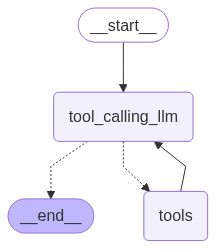

In [ ]:
### Node defintion
def tool_calling_llm(state: State) -> dict:
    """Call the LLM with the tools."""
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build the graph
graph = StateGraph(State)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

## Edges
graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges(
    "tool_calling_llm", 
    tools_condition,
)
graph.add_edge("tools", "tool_calling_llm")

graph_ = graph.compile()
# view
display(Image(graph_.get_graph().draw_mermaid_png()))

In [ ]:

messages = graph_.invoke({"messages": "Hey, what is the recent AI news and then please tell me about the latest research on quantum computing "})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hey, what is the recent AI news and then please tell me about the latest research on quantum computing 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f76nzphc7)
 Call ID: f76nzphc7
  Args:
    query: recent AI news 2024
  arxiv_query_run (ccrw0p5ym)
 Call ID: ccrw0p5ym
  Args:
    query: latest quantum computing research
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "2024: A year of extraordinary progress and advancement in AI", "url": "https://blog.google/technology/ai/2024-ai-extraordinary-progress-advancement/", "content": "This article summarizes Google's AI advancements in 2024, highlighting their commitment to responsible development.\n Google released Gemini 2.0, a powerful AI model designed for the \"agentic era,\" and integrated it into vario